In [12]:
# ==== IMPORTS ====
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Activation
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [14]:
# ==== CONFIGURATION ====
dataset_dir = "/content/drive/MyDrive/images"  # Change to your dataset path
image_size = 237
batch_size = 16
epochs = 30

In [15]:
# ==== DATA AUGMENTATION ====
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

train_data = datagen.flow_from_directory(
    dataset_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_data = datagen.flow_from_directory(
    dataset_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 1200 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


In [16]:

# ==== MODEL DEFINITION ====
def build_simple_cnn(image_size, num_classes):
    input_tensor = Input(shape=(image_size, image_size, 3))

    x = Conv2D(32, (3, 3), padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)

    return Model(inputs=input_tensor, outputs=output)

# ==== COMPILE MODEL ====
num_classes = train_data.num_classes
model = build_simple_cnn(image_size=image_size, num_classes=num_classes)
model.compile(optimizer=Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
# ==== CALLBACKS ====
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
]

In [18]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 237, 237, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 237, 237, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 237, 237, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 237, 237, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 118, 118, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 118, 118, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 118, 118, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 118, 118, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 59, 59, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 59, 59, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 59, 59, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 59, 59, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 29, 29, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 29, 29, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 29, 29, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 29, 29, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │    12,845,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,236,419 (50.49 MB)

 Trainable params: 13,235,459 (50.49 MB)

 Non-trainable params: 960 (3.75 KB)

In [19]:
# ==== TRAINING ====
history = model.fit(
    train_data,
    epochs=epochs,
    validation_data=val_data,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7040 - loss: 8.8718

75/75 ━━━━━━━━━━━━━━━━━━━━ 656s 9s/step - accuracy: 0.7051 - loss: 8.8193 - val_accuracy: 0.3967 - val_loss: 4.7624
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 26s 341ms/step - accuracy: 0.8900 - loss: 0.6367 - val_accuracy: 0.3333 - val_loss: 14.0212
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 339ms/step - accuracy: 0.9275 - loss: 0.3756 - val_accuracy: 0.3333 - val_loss: 18.7382
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 340ms/step - accuracy: 0.9486 - loss: 0.2416 - val_accuracy: 0.3833 - val_loss: 5.7049
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.9346 - loss: 0.3250

75/75 ━━━━━━━━━━━━━━━━━━━━ 26s 346ms/step - accuracy: 0.9346 - loss: 0.3246 - val_accuracy: 0.5100 - val_loss: 3.4044
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 343ms/step - accuracy: 0.9429 - loss: 0.3162 - val_accuracy: 0.5200 - val_loss: 6.8177
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 26s 343ms/step - accuracy: 0.9386 - loss: 0.1995 - val_accuracy: 0.5467 - val_loss: 10.2831
Epoch 8/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.9681 - loss: 0.1192

75/75 ━━━━━━━━━━━━━━━━━━━━ 26s 348ms/step - accuracy: 0.9680 - loss: 0.1194 - val_accuracy: 0.5800 - val_loss: 2.5469
Epoch 9/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.9773 - loss: 0.1192

75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 351ms/step - accuracy: 0.9773 - loss: 0.1191 - val_accuracy: 0.6633 - val_loss: 2.3050
Epoch 10/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 40s 342ms/step - accuracy: 0.9748 - loss: 0.0795 - val_accuracy: 0.5833 - val_loss: 6.3314
Epoch 11/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.9688 - loss: 0.1523

75/75 ━━━━━━━━━━━━━━━━━━━━ 27s 354ms/step - accuracy: 0.9689 - loss: 0.1516 - val_accuracy: 0.9467 - val_loss: 0.3325
Epoch 12/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.9587 - loss: 0.1916

75/75 ━━━━━━━━━━━━━━━━━━━━ 26s 352ms/step - accuracy: 0.9588 - loss: 0.1910 - val_accuracy: 0.9400 - val_loss: 0.1888
Epoch 13/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 27s 352ms/step - accuracy: 0.9658 - loss: 0.1591 - val_accuracy: 0.6567 - val_loss: 2.5213
Epoch 14/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 338ms/step - accuracy: 0.9367 - loss: 0.1959 - val_accuracy: 0.9267 - val_loss: 0.3229
Epoch 15/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.9397 - loss: 0.2584

75/75 ━━━━━━━━━━━━━━━━━━━━ 26s 351ms/step - accuracy: 0.9397 - loss: 0.2583 - val_accuracy: 0.9867 - val_loss: 0.0285
Epoch 16/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 26s 341ms/step - accuracy: 0.9494 - loss: 0.1838 - val_accuracy: 0.9867 - val_loss: 0.0494
Epoch 17/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 26s 344ms/step - accuracy: 0.9622 - loss: 0.1404 - val_accuracy: 0.9933 - val_loss: 0.0675
Epoch 18/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.9905 - loss: 0.0368

75/75 ━━━━━━━━━━━━━━━━━━━━ 26s 350ms/step - accuracy: 0.9904 - loss: 0.0370 - val_accuracy: 0.9933 - val_loss: 0.0237
Epoch 19/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 26s 342ms/step - accuracy: 0.9771 - loss: 0.0973 - val_accuracy: 0.9067 - val_loss: 1.5272
Epoch 20/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 339ms/step - accuracy: 0.9712 - loss: 0.1200 - val_accuracy: 0.9767 - val_loss: 0.0702
Epoch 21/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 339ms/step - accuracy: 0.9811 - loss: 0.0612 - val_accuracy: 0.9933 - val_loss: 0.0589
Epoch 22/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 328ms/step - accuracy: 0.9795 - loss: 0.0747 - val_accuracy: 0.5733 - val_loss: 4.1575
Epoch 23/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 326ms/step - accuracy: 0.9701 - loss: 0.1125 - val_accuracy: 0.8067 - val_loss: 0.3790


In [20]:
# ==== EVALUATION ====
val_steps = val_data.samples // val_data.batch_size + 1
val_data.reset()
preds = model.predict(val_data, steps=val_steps, verbose=1)

if num_classes == 2:
    y_pred = (preds > 0.5).astype(int).flatten()
else:
    y_pred = np.argmax(preds, axis=1)

y_true = val_data.classes
labels = list(train_data.class_indices.keys())

print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=labels))

print("=== Confusion Matrix ===")
print(confusion_matrix(y_true, y_pred))

19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 268ms/step

=== Classification Report ===
              precision    recall  f1-score   support

       elias       0.99      0.99      0.99       100
        naim       0.99      1.00      1.00       100
        siam       1.00      0.99      0.99       100

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300

=== Confusion Matrix ===
[[ 99   1   0]
 [  0 100   0]
 [  1   0  99]]


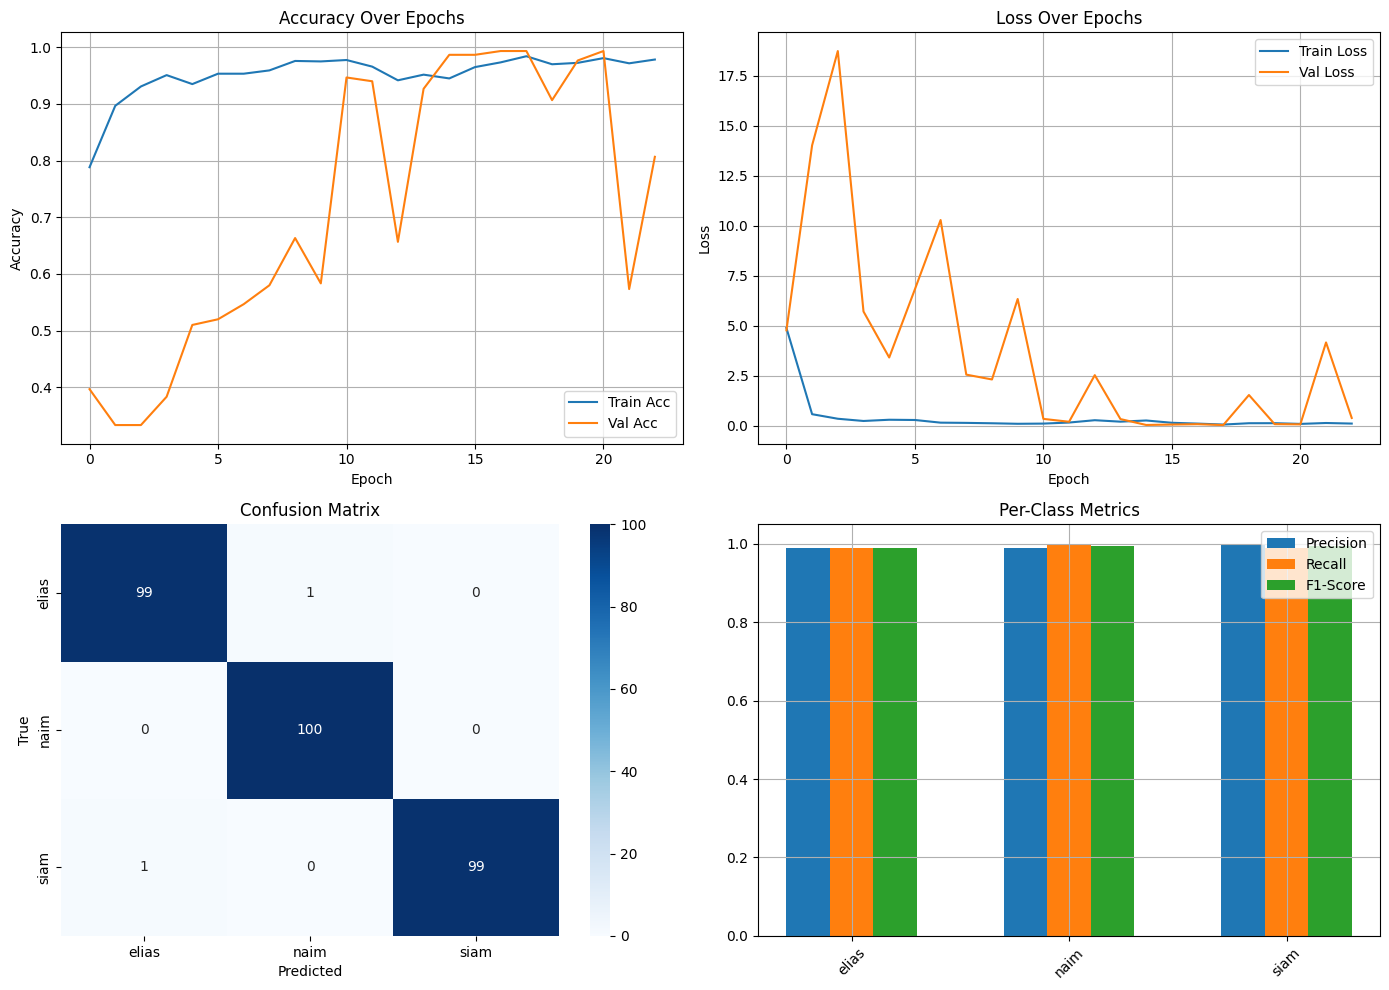

In [21]:
# ==== DASHBOARD ====
plt.figure(figsize=(14, 10))

# Accuracy
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Confusion Matrix
plt.subplot(2, 2, 3)
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

# Per-Class Metrics
plt.subplot(2, 2, 4)
report = classification_report(y_true, y_pred, target_names=labels, output_dict=True)
metrics = ['precision', 'recall', 'f1-score']
scores = {m: [report[label][m] for label in labels] for m in metrics}

x = np.arange(len(labels))
w = 0.2
plt.bar(x - w, scores['precision'], width=w, label='Precision')
plt.bar(x, scores['recall'], width=w, label='Recall')
plt.bar(x + w, scores['f1-score'], width=w, label='F1-Score')
plt.xticks(ticks=x, labels=labels, rotation=45)
plt.ylim(0, 1.05)
plt.title('Per-Class Metrics')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [22]:
import json

# ==== SAVE MODEL ====
model.save('model_final.h5')
print("Model saved to model_final.h5")

# ==== SAVE CLASS INDICES ====
with open('class_indices.json', 'w') as f:
    json.dump(train_data.class_indices, f)
print("Class indices saved to class_indices.json")

Model saved to model_final.h5
Class indices saved to class_indices.json
